# **Softmax Regression for MNIST Handwritten Digit Classification**
Huy G. Tong\
*Faculty of Information Technology, VNUHCM - University of Science, Vietnam*

## **ABSTRACT**
I present a simple classification model using softmax regression. The model is trained and tested on the MNIST handwritten digit dataset. In this Notebook, I will perform pre-processing of the given data, then a model will be trained using the gradient descent method for minimizing cross-entropy error. Finally, some sample predictions made by the model will be presented and evaluated.

## **IMPLEMENTATION**
First and foremost, let us import the necessary libraries. Run the bellow cell **AT LEAST ONCE** when working with this Notebook:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import gzip

# To check elapsed time
import time
from datetime import timedelta

### **Data**

The included [MNIST dataset](http://yann.lecun.com/exdb/mnist/) include 60.000 training images and 10.000 testing images. Here, the included data (`mnist.pkl.gz` file) is split into 3 sets: training set (50.000 images), validating set (10.000 images), and testing set (10.000 images). The train and validate sets are obtained by splitting the original training set in 5:1 ratio.

The bellow cell will load the data and print out some properties:

In [2]:
def read_mnist(mnist_file):
    if os.path.isfile(mnist_file) == False:
        mnist_file = os.path.join(os.path.expanduser('~'), 'data', 'mnist.pkl.gz')
    
    f = gzip.open(mnist_file, 'rb')
    train_data, val_data, test_data = pickle.load(f, encoding='latin1')
    f.close()
    
    train_X, train_Y = train_data
    val_X, val_Y = val_data
    test_X, test_Y = test_data    
    
    return train_X, train_Y, val_X, val_Y, test_X, test_Y

train_X, train_y, val_X, val_y, test_X, test_y = read_mnist('mnist.pkl.gz')
print(f'Shape of train_X: {train_X.shape}, shape of train_y: {train_y.shape}')
print(f'Shape of val_X:   {val_X.shape}, shape of val_y:   {val_y.shape}')
print(f'Shape of test_X:  {test_X.shape}, shape of test_y:  {test_y.shape}')

Shape of train_X: (50000, 784), shape of train_y: (50000,)
Shape of val_X:   (10000, 784), shape of val_y:   (10000,)
Shape of test_X:  (10000, 784), shape of test_y:  (10000,)


From the outputs, our input will be a matrix, where each row is the flattened image array, and the output is a vector of labels indicating which number the image is.

Let us view some sample images from the dataset with the cell bellow (credit goes to my lab instructor):

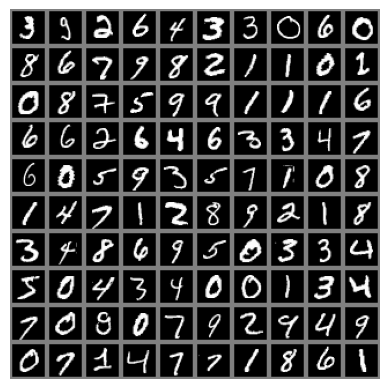

In [3]:
n_rimages = 10; n_cimages = 10 
padding = 2 
canvas = 0.5 * np.ones((n_rimages * (28 + 2 * padding), n_cimages * (28 + 2 * padding)))
rand_idxs = np.random.permutation(np.arange(len(train_X))[:n_rimages * n_cimages])

for r in range(n_rimages):
    for c in range(n_cimages):
        i = r * n_cimages + c
        image = train_X[rand_idxs[i]].reshape(28, 28)
        temp1 = r * (28 + 2 * padding) + padding 
        temp2 = c * (28 + 2 * padding) + padding 
        canvas[temp1:temp1 + 28, temp2:temp2 + 28] = image

plt.imshow(canvas, cmap='gray', vmin=0, vmax=1)
plt.grid(None) 
plt.axis('off')
plt.show()

### **Data pre-processing**

Instead of using the original input matrix, we will preprocess it to make the model perform better.
The adjustments include:
- adding 1s to the left end of the input matrix (see function `add_ones()`)
- adding intensity and symmetry measurement to the right end of the matrix (see function `add_features()`)

The cell bellow defines the necessary functions for data processing and training the model:

In [4]:
def add_ones(X):
    return np.hstack((np.ones((len(X), 1)), X))


def add_features(X, mins=None, maxs=None):
    '''
    Add intensity and symmetry measurement
    to the right end of the input matrix
    '''

    intensity = np.mean(X, axis=1, keepdims=True)
    
    # Get the images
    imgs = X.reshape((X.shape[0], 28, 28))
    flipped_h = np.flip(imgs, axis=2)
    flipped_v = np.flip(imgs, axis=1)

    s1 = np.mean(np.abs(imgs - flipped_h), axis=(1, 2))
    s2 = np.mean(np.abs(imgs - flipped_v), axis=(1, 2))
    symmetry = -1.*(s1 + s2)/2
    symmetry = np.expand_dims(symmetry, axis=1)

    if mins is None or maxs is None:
        mins = np.array([intensity.min(), symmetry.min()])
        maxs = np.array([intensity.max(), symmetry.max()])

        # Normalize
        intensity = (intensity - mins[0]) / (maxs[0] - mins[0])
        symmetry = (symmetry - mins[1]) / (maxs[1] - mins[1])

        Z = np.concatenate([X, intensity, symmetry], axis=1)

        return Z, mins, maxs

    # Normalize
    intensity = (intensity - mins[0]) / (maxs[0] - mins[0])
    symmetry = (symmetry - mins[1]) / (maxs[1] - mins[1])

    Z = np.concatenate([X, intensity, symmetry], axis=1)

    return Z


def softmax(W, X, return_prob=True):
    y = X @ W
    p = np.exp(y) / np.sum(np.exp(y), axis=1, keepdims=True)
    if return_prob: return p
    return np.argmax(p, axis=1)


def onehot(y):
    encoded = np.zeros((y.shape[0], y.max() + 1))
    encoded[np.arange(len(y)), y] = 1
    return encoded


def train(X, y, lr, max_epoch, initial_W=None):
    '''
    Minimize the cross-entropy error using
    gradient descent
    '''

    W = initial_W
    if W is None:
        W = np.zeros((X.shape[1], len(np.unique(y))))

    # Cross-entropy Errors
    cees = []
    
    # Add extra loop to compute cross-entropy errors
    for i in range(max_epoch + 1):
        y_pred = softmax(W, X)

        # Ignore error of initial pass
        if i > 0:
            ce_error = -1.*np.sum(onehot(y)*np.log(y_pred))/X.shape[0]
            cees.append(ce_error)

        # Gradient descent step
        if i < max_epoch:
            dE = (X.T @ (y_pred - onehot(y))) / X.shape[0]
            W -= lr*dE

    return W, cees


def mbe(predicted_y, y):
    return np.mean(predicted_y != y) * 100

Let us preprocess the data by adding ones to the beginning of the input matrix, and compute and incorporate the intensity and symmetry values to the end of the matrix.

In [5]:
train_Z, mins_for_add_features, maxs_for_add_features = add_features(train_X)
train_Z = add_ones(train_Z)
train_Z.shape

(50000, 787)

### **Train the model using the processed data**

In [6]:
start = time.time()
W, train_ces = train(train_Z, train_y, lr=0.3, max_epoch=500)
print(f"-- Training finished in: {timedelta(seconds=time.time() - start)}")

predicted_train_y = softmax(W, train_Z, return_prob=False)
train_mbe = mbe(predicted_train_y, train_y)
print(f"-- Training error: {train_mbe}")

-- Training finished in: 0:01:25.220505
-- Training error: 9.116


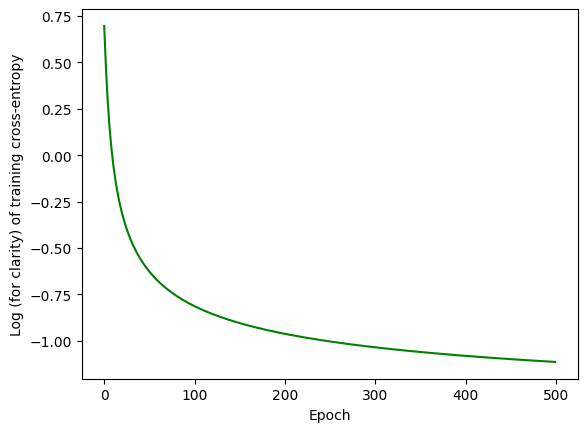

In [7]:
plt.plot(np.log(train_ces), color='green')
plt.xlabel('Epoch')
plt.ylabel('Log (for clarity) of training cross-entropy')
plt.show()

### **Validate and test the model**

In [8]:
val_Z = add_ones(add_features(val_X, mins_for_add_features, maxs_for_add_features))
predicted_val_y = softmax(W, val_Z, return_prob=False)
val_mbe = mbe(predicted_val_y, val_y)
print(f"-- Validation error: {val_mbe}")

-- Validation error: 8.27


In [9]:
test_Z = add_ones(add_features(test_X, mins_for_add_features, maxs_for_add_features))
predicted_test_y = softmax(W, test_Z, return_prob=False)
test_mbe = mbe(predicted_test_y, test_y)
print(f"-- Test error: {test_mbe}")

-- Test error: 8.6


### **Results**
We can observe some of the predicted output by running the cell bellow. The correctly predicted labels are colored in green and incorrect ones are in red.

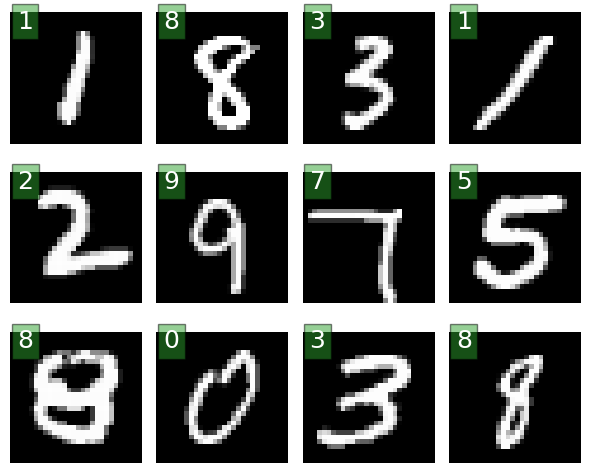

In [10]:
# Draw some samples
sampos = np.random.choice(test_X.shape[0], size=(3, 4), replace=False)

fig, ax = plt.subplots(3, 4)
for i in range(4):
    
    # Get images and predicted labels
    img1 = test_X[sampos[0][i]]
    img1 = img1.reshape((28, 28))
    label1 = predicted_test_y[sampos[0][i]]
    truth1 = test_y[sampos[0][i]]

    img2 = test_X[sampos[1][i]]
    img2 = img2.reshape((28, 28))
    label2 = predicted_test_y[sampos[1][i]]
    truth2 = test_y[sampos[1][i]]

    img3 = test_X[sampos[2][i]]
    img3 = img3.reshape((28, 28))
    label3 = predicted_test_y[sampos[2][i]]
    truth3 = test_y[sampos[2][i]]


    # Plot the outputs
    label_color = "tab:green" if label1 == truth1 else "tab:red"
    ax[0][i].imshow(img1, cmap="gray")
    ax[0][i].axis("off")
    ax[0][i].text(
        1, 3, label1, fontsize=18, color="white", 
        bbox=dict(facecolor=label_color, alpha=0.5)
    )

    label_color = "tab:green" if label2 == truth2 else "tab:red"
    ax[1][i].imshow(img2, cmap="gray")
    ax[1][i].axis("off")
    ax[1][i].text(
        1, 3, label2, fontsize=18, color="white", 
        bbox=dict(facecolor=label_color, alpha=0.5)
    )

    label_color = "tab:green" if label3 == truth3 else "tab:red"
    ax[2][i].imshow(img3, cmap="gray")
    ax[2][i].axis("off")
    ax[2][i].text(
        1, 3, label3, fontsize=18, color="white", 
        bbox=dict(facecolor=label_color, alpha=0.5)
    )

fig.set_size_inches((6, 5))
plt.tight_layout()
plt.show()

## **ACKNOWLEDGEMENTS**
This notebook is derived and translated from a homework of the **[HCMUS](https://en.wikipedia.org/wiki/Ho_Chi_Minh_City_University_of_Science)**' *Introduction to Machine Learning* course. I would like to thank the lecturers and lab instructor of the course for their instruction in theory and lab session, as well as support during the assignment duration. The majority of the code blocks in this Notebook is kept the same as in the submission template provided by the lab instructor, some sections used for grading have been removed.